## NOTE: This notebook is adjusted from Toby Wise's reduction of the questionnaire items: [https://github.com/tobywise/online-aversive-learning](https://github.com/tobywise/online-aversive-learning) [(notebook)](https://github.com/tobywise/online-aversive-learning/blob/master/notebooks/questionnaire_analysis.ipynb). Item weights are recalculated due a coding error in our pilot experiments where a few items were missing (in the Liebowitz social anxiety scale).

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import joblib
import os
from pathlib import Path

from costometer.utils import set_font_sizes

set_font_sizes()

/home/vfelso/github/irl-project/venv/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:348: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/vfelso/github/irl-project/venv/lib/python3.8/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/vfelso/github/irl-project/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading

As was previously done, we load in the data from [Rouault et al (2018)](http://www.sciencedirect.com/science/article/pii/S0006322318300295), which is available [here](https://github.com/metacoglab/RouaultSeowGillanFleming/).

In [2]:
qns = pd.read_csv('data/rouault_et_al/qns.csv', index_col=0)
scores = pd.read_csv('data/rouault_et_al/scores.csv', index_col=0)

In [3]:
qns.head()

,qnid,zung.1,zung.2,zung.3,zung.4,zung.5,zung.6,zung.7,zung.8,zung.9,...,apathy.9,apathy.10,apathy.11,apathy.12,apathy.13,apathy.14,apathy.15,apathy.16,apathy.17,apathy.18
1,4048436,1,2,1,1,2,1,2,1,1,...,1,1,1,1,3,2,2,1,2,2
2,4784881,4,4,2,4,4,4,4,4,3,...,1,3,4,4,4,3,4,4,4,4
3,5606197,1,3,1,1,2,3,1,1,1,...,2,3,3,2,1,2,2,3,3,2
4,1247914,3,4,1,3,4,4,4,1,1,...,3,1,2,4,4,3,2,2,3,3
5,1614684,1,3,1,1,2,1,1,2,1,...,1,1,1,1,2,1,1,1,1,1


We also load in the actual items that we had. I will use the second questionnaire pilot wave since there no one saw the full questionnaire battery.

In [4]:
new_questionnaires = pd.read_csv(Path().resolve().parents[1].joinpath("data/processed/quest_second/individual_items.csv"))

Note that the Liebowitz social anxiety items are not yet combined in our data, but it is in the Rouault et al. data ("For the social anxiety questionnaire (LSAS), the average of the avoidance and fear/anxiety answers of each item was taken"):

In [5]:
LSAS_new = [item for item in list(new_questionnaires) if "leb" in item]
LSAS_old = [item for item in list(qns) if "leb" in item]
print(LSAS_new)
print(LSAS_old)

['leb.13', 'leb.14', 'leb.15', 'leb.19', 'leb.2', 'leb.21', 'leb.22', 'leb.23', 'leb.24', 'leb.27', 'leb.29', 'leb.3', 'leb.30', 'leb.31', 'leb.32', 'leb.35', 'leb.39', 'leb.4', 'leb.40', 'leb.45', 'leb.46', 'leb.48']
['leb.1', 'leb.2', 'leb.3', 'leb.4', 'leb.5', 'leb.6', 'leb.7', 'leb.8', 'leb.9', 'leb.10', 'leb.11', 'leb.12', 'leb.13', 'leb.14', 'leb.15', 'leb.16', 'leb.17', 'leb.18', 'leb.19', 'leb.20', 'leb.21', 'leb.22', 'leb.23', 'leb.24']


So we combine the items quickly, and drop those without its match:

In [6]:
for item in range(1, 25):
    if f"leb.{item}" in new_questionnaires and f"leb.{item+24}" in new_questionnaires:
        print(f"leb.{item}", f"leb.{item+24}")
        new_val = new_questionnaires[f"leb.{item}"]+new_questionnaires[f"leb.{item+24}"]
        del new_questionnaires[f"leb.{item}"]
        del new_questionnaires[f"leb.{item+24}"]
        new_questionnaires[f"leb.{item}"] = new_val/2
    elif f"leb.{item}" in new_questionnaires :
        del new_questionnaires[f"leb.{item}"]
    elif f"leb.{item+24}" in new_questionnaires:
        del new_questionnaires[f"leb.{item+24}"]

leb.3 leb.27
leb.15 leb.39
leb.21 leb.45
leb.22 leb.46
leb.24 leb.48


/tmp/ipykernel_42340/3138693178.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_questionnaires[f"leb.{item}"] = new_val/2
/tmp/ipykernel_42340/3138693178.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_questionnaires[f"leb.{item}"] = new_val/2
/tmp/ipykernel_42340/3138693178.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmen

In [7]:
# now we should only have the five items combined above
[item for item in list(new_questionnaires) if "leb" in item]

['leb.3', 'leb.15', 'leb.21', 'leb.22', 'leb.24']

In [8]:
# take list intersection of previous data and new data
new_items = list(set(list(new_questionnaires)).intersection(list(qns)))


#remove cols we don't have
new_qns = qns.copy()
new_qns = new_qns[[col for col in list(qns) if col in ["qnid"]+new_items]]

## Prediction model

Here, rather than using LASSO regression we use plain old regression since we want to use as much data as we have (only 55 items).


In [9]:
clf = LinearRegression()
pred = cross_val_predict(clf, new_qns.iloc[:, 1:], scores.iloc[:, 1:], cv=5)
clf.fit(new_qns.iloc[:, 1:], scores.iloc[:, 1:]);

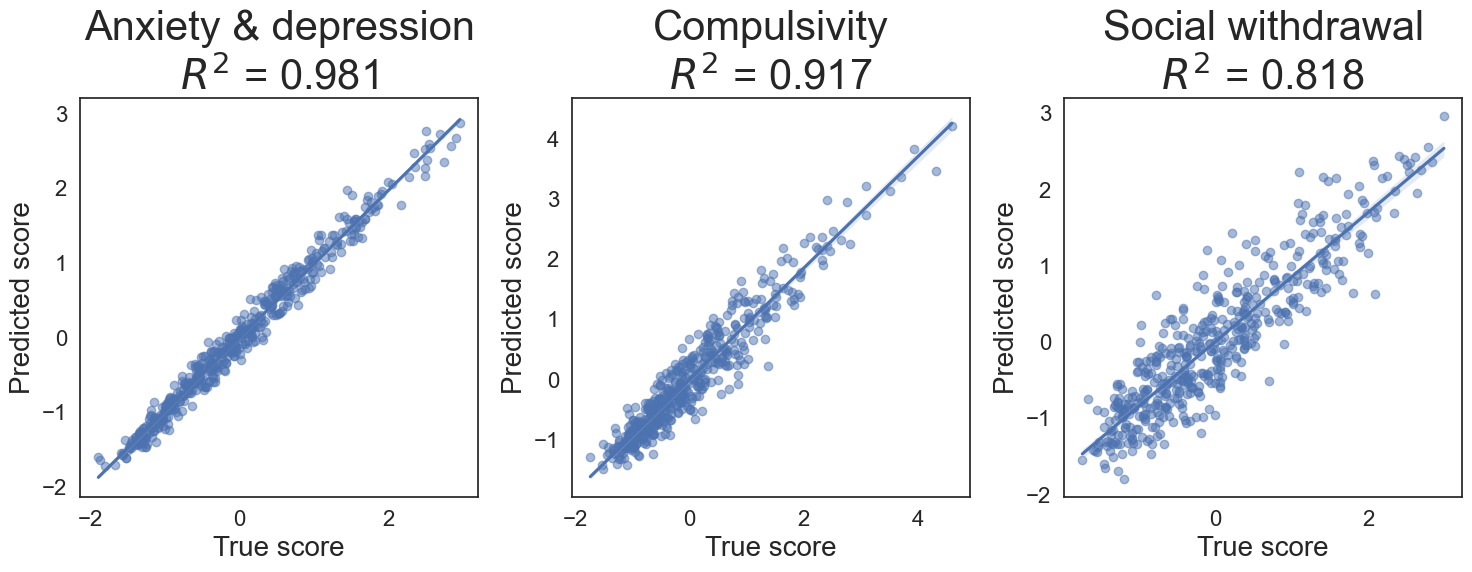

In [10]:
f, ax = plt.subplots(1, 3, figsize=(15, 6), dpi=100, facecolor='white')

factors = ['Anxiety & depression', 'Compulsivity', 'Social withdrawal']

for i in range(3):
    sns.regplot(x=scores.iloc[:, i+1], y=pred[:, i], ax=ax[i], scatter_kws={'alpha': 0.5})
    ax[i].set_title(factors[i] + '\n$R^2$ = {0}'.format(np.round(r2_score(scores.iloc[:, i+1], pred[:, i]), 3)), fontweight='light')
    ax[i].set_xlabel('True score')
    ax[i].set_ylabel('Predicted score')
    
plt.tight_layout()
plt.savefig('figs/factors/factor_prediction.svg')

The previous $R^2$ was 0.806, these $R^2$s seem fine. The social withdrawal might be a bit lower due to the issue with the social anxiety scale.

## View coefficients

In [11]:
coefs = clf.coef_.T
values = coefs[np.any(coefs != 0, axis=1)].T
labels = new_qns.columns[1:][np.any(coefs != 0, axis=1)]

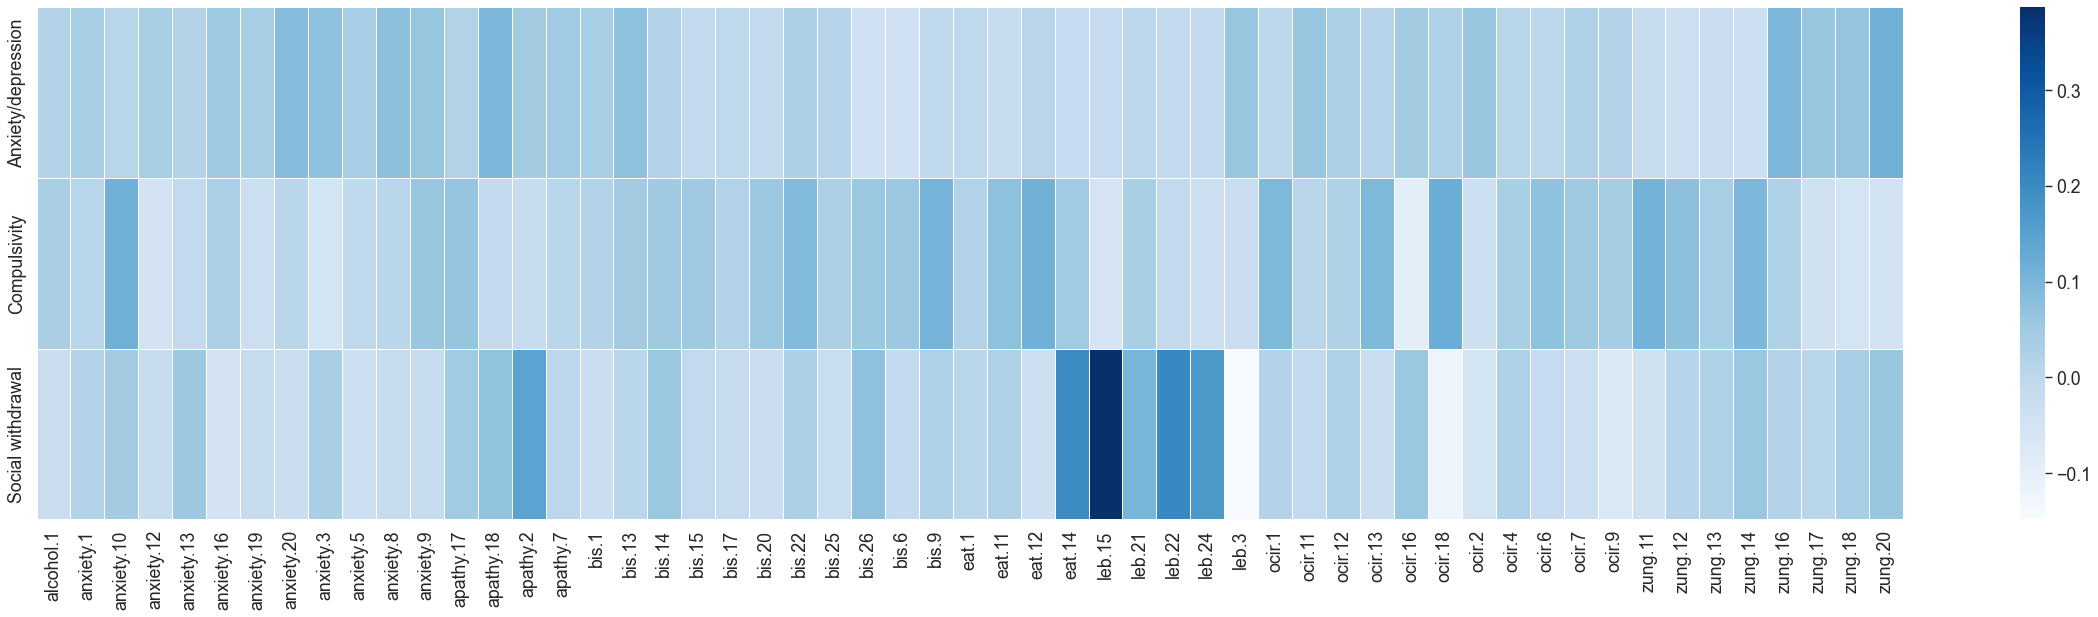

In [12]:
plt.figure(figsize=(30, 8), dpi=80, facecolor='white')
coefs = clf.coef_.T
sns.heatmap([val for _, val in sorted(zip(labels, values))], cmap="Blues", xticklabels=sorted(labels),
           yticklabels=['Anxiety/depression', 'Compulsivity', 'Social withdrawal'], linewidths=.5);
plt.xticks(rotation=90);
plt.tight_layout()
plt.savefig('figs/factors/retained_questions.svg')

## Save the classifier

In [13]:
joblib.dump(clf, 'inputs/loadings/Modified_WiseEtAl2020_classifier.pkl') 

['inputs/loadings/Modified_WiseEtAl2020_classifier.pkl']

## Save the item weights to csv

In [14]:
weight_df = pd.DataFrame(coefs, columns=['Anxiety/depression', 'Compulsivity', 'Social withdrawal'], index=np.arange(coefs.shape[0]))
weight_df['item'] = new_qns.columns[1:]
weight_df.head()
weight_df.to_csv('inputs/loadings/Modified_WiseEtAl2020_weights.csv', index=None)